# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV54"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv54')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv54/lv54-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 15:49:05,888 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP017575, SRP006575, SRP036821, SRP008218, SRP019994, SRP023262, SRP010038, SRP004965, SRP040292, SRP052706, SRP060416, SRP051249, SRP055569, SRP042620, SRP066834, SRP036053, SRP000599, SRP018359, SRP014146, SRP043162, SRP039338, SRP035988, SRP055749, SRP042086, SRP007359, SRP053101, SRP045154, SRP041538, SRP055512, SRP060355, SRP030617, SRP012656, SRP011924, SRP052978, SRP042161, SRP053190, SRP033135, SRP052991, SRP063838, SRP061888, SRP021478, SRP029899, SRP050971, SRP058773, SRP041718, SRP064464, SRP014739, SRP003726, SRP043166, SRP053098, SRP057196, SRP021193, 

In [19]:
lv_data.shape

(5736, 70)

In [20]:
lv_data.head()

tissue tissue archive method    stromal signature  \
project   run                                                                 
SRP017575 SRR633556  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633557  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633558  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633559  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633560  Soft Tissue                  FFPE  DTF(3SEQ) signature   

                    prognosis cell line cell type developmental stage  \
project   run                                                           
SRP017575 SRR633556   UNCLEAR       NaN       NaN                 NaN   
          SRR633557   UNCLEAR       NaN       NaN                 NaN   
          SRR633558   UNCLEAR       NaN       NaN                 NaN   
          SRR633559   UNCLEAR       NaN       NaN                 NaN   
          SRR633560   UNCLEAR       NaN       NaN                 NaN   

                    disease status tissue subtype source  ...  \
project   run                                             ...   
SRP017575 SRR633556            NaN            NaN    NaN  ...   
          SRR633557            NaN            NaN    NaN  ...   
          SRR633558            NaN            NaN    NaN  ...   
          SRR633559            NaN            NaN    NaN  ...   
          SRR633560            NaN            NaN    NaN  ...   

                    assigned cell type qc pass cell count ercc_dilution  \
project   run                                                             
SRP017575 SRR633556                NaN     NaN        NaN           NaN   
          SRR633557                NaN     NaN        NaN           NaN   
          SRR633558                NaN     NaN        NaN           NaN   
          SRR633559                NaN     NaN        NaN           NaN   
          SRR633560                NaN     NaN        NaN           NaN   

                    patient condition race c1 chip id experiment_sample_name  \
project   run                                                                  
SRP017575 SRR633556               NaN  NaN        NaN                    NaN   
          SRR633557               NaN  NaN        NaN                    NaN   
          SRR633558               NaN  NaN        NaN                    NaN   
          SRR633559               NaN  NaN        NaN                    NaN   
          SRR633560               NaN  NaN        NaN                    NaN   

                    lvad support      LV54  
project   run                               
SRP017575 SRR633556          NaN  0.175936  
          SRR633557          NaN  0.210196  
          SRR633558          NaN  0.433927  
          SRR633559          NaN  0.298636  
          SRR633560          NaN  0.209013  

[5 rows x 70 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

stromal signature        0.258559
prognosis                0.258559
tissue subtype           0.192408
antibody catalog #       0.186369
antibody vender          0.186369
parity                   0.165466
source                   0.150730
tissue archive method    0.143057
cell marker              0.058868
patient                  0.041685
disease status           0.038682
developmental stage      0.038682
passages                 0.037933
subtypes                 0.031722
tissue id                0.028897
patient number           0.028897
tissue                   0.024750
treatment                0.024434
age in weeks             0.016083
disease state            0.011949
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue subtype    0.192408
tissue            0.024750
cell type         0.004538
tissue type       0.002226
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        "tissue subtype",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

cell type               tissue  \
project   run                                                             
SRP010038 SRR392881                 Pterygia cells                  NaN   
SRP008218 SRR343345    bead purified stromal cells               breast   
SRP040292 SRR1199126                           NaN        adrenal tumor   
SRP023262 SRR868868                            NaN               breast   
SRP010038 SRR392897                 Pterygia cells                  NaN   
          SRR392896                 Pterygia cells                  NaN   
SRP023262 SRR868867                            NaN               breast   
SRP019994 SRR797140                            NaN          Soft Tissue   
SRP052706 SRR1768046          queiscent fibroblast                  NaN   
SRP036821 SRR1163277                           NaN  soft tissue sarcoma   
SRP010038 SRR392889                 Pterygia cells                  NaN   
SRP052706 SRR1768047          queiscent fibroblast                  NaN   
SRP023262 SRR868866                            NaN               breast   
SRP006575 SRR537107                            NaN                 lung   
SRP010038 SRR392882                 Pterygia cells                  NaN   
SRP017575 SRR633601                            NaN          Soft Tissue   
          SRR633587                            NaN          Soft Tissue   
SRP060416 SRR2088309  tonsil Innate lymphoid cells                  NaN   
SRP010038 SRR392895                 Pterygia cells                  NaN   
SRP017575 SRR633572                            NaN          Soft Tissue   
          SRR633585                            NaN          Soft Tissue   
          SRR633598                            NaN          Soft Tissue   
SRP010038 SRR392872                 Pterygia cells                  NaN   
          SRR392871                 Pterygia cells                  NaN   
SRP017575 SRR633576                            NaN          Soft Tissue   

                     tissue type tissue subtype      LV54  
project   run                                              
SRP010038 SRR392881          NaN            NaN  0.601990  
SRP008218 SRR343345          NaN            NaN  0.596036  
SRP040292 SRR1199126         NaN            NaN  0.589827  
SRP023262 SRR868868          NaN            NaN  0.576066  
SRP010038 SRR392897          NaN            NaN  0.573547  
          SRR392896          NaN            NaN  0.572240  
SRP023262 SRR868867          NaN            NaN  0.571127  
SRP019994 SRR797140          NaN            NaN  0.563327  
SRP052706 SRR1768046         NaN            NaN  0.558763  
SRP036821 SRR1163277         NaN           TGCT  0.547370  
SRP010038 SRR392889          NaN            NaN  0.538014  
SRP052706 SRR1768047         NaN            NaN  0.534443  
SRP023262 SRR868866          NaN            NaN  0.534199  
SRP006575 SRR537107          NaN            NaN  0.534114  
SRP010038 SRR392882          NaN            NaN  0.532116  
SRP017575 SRR633601          NaN            NaN  0.524074  
          SRR633587          NaN            NaN  0.515271  
SRP060416 SRR2088309         NaN            NaN  0.505925  
SRP010038 SRR392895          NaN            NaN  0.502717  
SRP017575 SRR633572          NaN            NaN  0.502240  
          SRR633585          NaN            NaN  0.494837  
          SRR633598          NaN            NaN  0.486765  
SRP010038 SRR392872          NaN            NaN  0.482302  
          SRR392871          NaN            NaN  0.479016  
SRP017575 SRR633576          NaN            NaN  0.477923

In [26]:
# what is there in these projects?
lv_data.loc[["SRP017575"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

tissue tissue archive method stromal signature  \
project   run                                                              
SRP017575 SRR633580  Soft Tissue                  FFPE      EF signature   
          SRR633579  Soft Tissue                  FFPE      EF signature   
          SRR633581  Soft Tissue                  FFPE      EF signature   
          SRR633594  Soft Tissue                  FFPE    NPAF signature   
          SRR633578  Soft Tissue                  FFPE      EF signature   
          SRR633586  Soft Tissue                  FFPE      PF signature   
          SRR633588  Soft Tissue                  FFPE      PF signature   
          SRR633567  Soft Tissue                  FFPE     SFT signature   
          SRR633574  Soft Tissue                  FFPE      FC signature   
          SRR633601  Soft Tissue                  FFPE    FOTS signature   

                    prognosis      LV54  
project   run                            
SRP017575 SRR633580      GOOD  2.781848  
          SRR633579      GOOD  1.969545  
          SRR633581      GOOD  1.590585  
          SRR633594   UNCLEAR  1.200086  
          SRR633578      GOOD  1.184456  
          SRR633586   UNCLEAR  1.030491  
          SRR633588   UNCLEAR  0.986030  
          SRR633567   UNCLEAR  0.856877  
          SRR633574   UNCLEAR  0.674082  
          SRR633601       BAD  0.524074

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type      LV54
project   run                                               
SRP017575 SRR633580                    Soft Tissue  2.781848
SRP006575 SRR191718   dedifferentiated liposarcoma  2.532321
SRP036821 SRR1163261           soft tissue sarcoma  2.509484
SRP017575 SRR633579                    Soft Tissue  1.969545
          SRR633581                    Soft Tissue  1.590585
SRP008218 SRR343344    bead purified stromal cells  1.413698
SRP017575 SRR633594                    Soft Tissue  1.200086
          SRR633578                    Soft Tissue  1.184456
SRP019994 SRR797093                    Soft Tissue  1.169782
SRP017575 SRR633586                    Soft Tissue  1.030491
          SRR633588                    Soft Tissue  0.986030
SRP006575 SRR191716   dedifferentiated liposarcoma  0.927533
SRP036821 SRR1163262           soft tissue sarcoma  0.914062
SRP017575 SRR633567                    Soft Tissue  0.856877
SRP006575 SRR191695             myxoid liposarcoma  0.820552
          SRR191696             myxoid liposarcoma  0.812551
SRP023262 SRR868869                         breast  0.708520
SRP036821 SRR1163245           soft tissue sarcoma  0.692212
SRP017575 SRR633574                    Soft Tissue  0.674082
SRP010038 SRR392874                 Pterygia cells  0.669704

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "Soft Tissue": "Leiomyosarcoma",
        }
    }
)

In [34]:
# add also tissue information to these projects
_srp_code = "SRP017575"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "Soft tissue tumor"
    + f" ({lv_data.loc[(_srp_code, x.name), 'stromal signature']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP036821"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "tissue"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue subtype']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-c8958257afd6>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-34-c8958257afd6>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Myeloma cells" if x.name[0] in ("SRP027015",) else x["cell type"],
    axis=1,
)

In [36]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [37]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [38]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [39]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [40]:
len(attr_order)

25

In [41]:
attr_order[:5]

['Soft tissue tumor (EF signature)',
 'dedifferentiated liposarcoma',
 'soft tissue sarcoma (DDLPS)',
 'bead purified stromal cells',
 'Soft tissue tumor (NPAF signature)']

## Plot

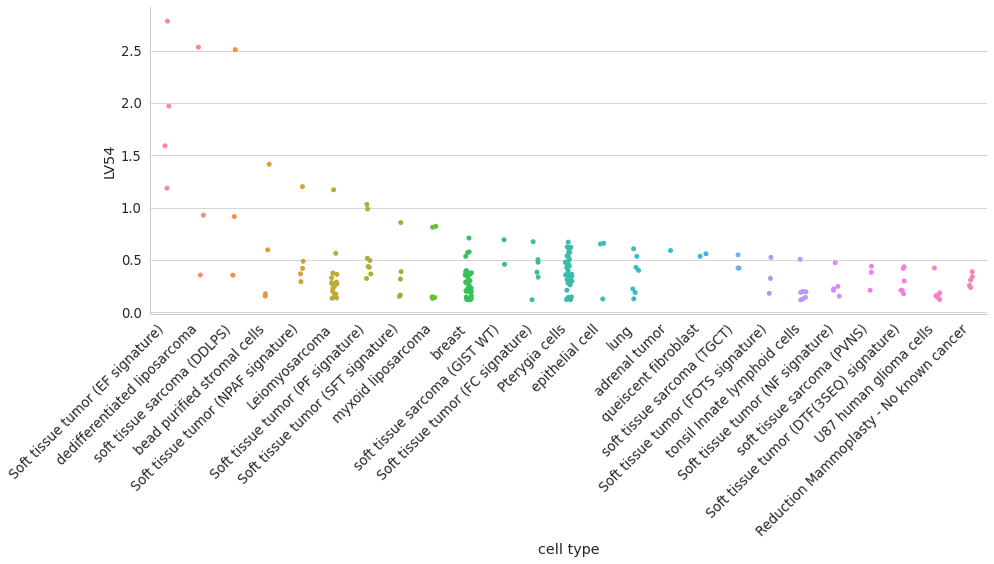

In [42]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [43]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[
#         final_plot_data[SELECTED_ATTRIBUTE].str.contains("Soft Tissue")
#     ]
#     display(_tmp.head(20))

In [44]:
# # what is there in these projects?
# lv_data.loc[["SRP019994"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)